In [33]:
import wfdb


record = wfdb.rdsamp('Datasets/files/04126') 
annotation = wfdb.rdann('Datasets/files/04126', 'atr') 

(0.0, 600.0)

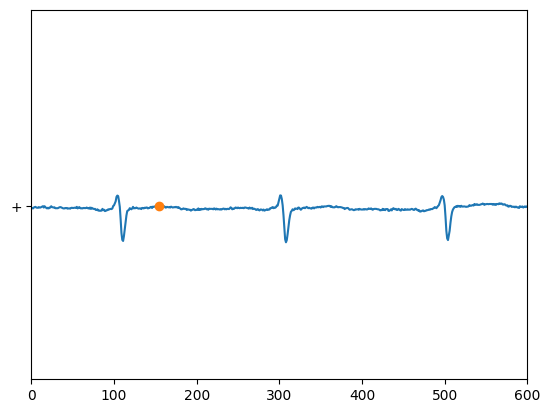

In [64]:
import matplotlib.pyplot as plt

plt.plot(record[0][:,0])
plt.plot(annotation.sample,annotation.symbol, 'o')
plt.xlim(0,600)

In [65]:
record = wfdb.rdsamp('Datasets/files/08378') 
annotation = wfdb.rdann('Datasets/files/08378', 'atr') 

604953
(AFL


(604353.0, 605553.0)

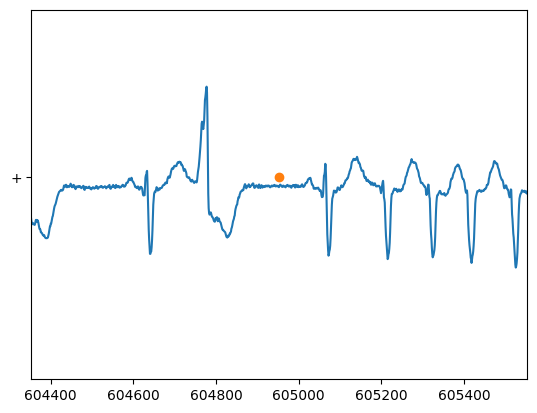

In [75]:
plt.plot(record[0][:,0])
plt.plot(annotation.sample,annotation.symbol, 'o')
print(annotation.sample[1])
print(annotation.aux_note[1])
plt.xlim(604353,605553)